# Cell-Based Association

This ipynb file showcases how to use the CBA class.

Cell-Based Association is used as a pre-processing method for geological data, such as geological maps and structural data. This method allows identifying specific associations of geological features across a given area (i.e. geological environments) using a regular square grid. Associations of geological features are identified and synthetized into unique binary codes, representing the absence or presence of each variable inside the environments.

This method allows the analysis of point-environments relationship. Known occurences define mineralized environments, which are used to compute favorability score, using various methods. Such methods include Agglomerative Hierarchical Clustering (AHC), Ranking (lithology/mineralization ratios) or Random Forest (RF) for instance.

For more details about the CBA, see for instance: 

**Tourlière, B., Pakyuz-Charrier, E., Cassard, D., Barbanson, L., & Gumiaux, C. (2015)**. *Cell Based Associations: A procedure for considering scarce and mixed mineral occurrences in predictive mapping*. Computers & geosciences, 78, 53-62.

**A. Vella (2022)**. *Highlighting mineralized geological environments through a new Data-driven predictive mapping approach*. PhD Thesis, University of Orléans, France.


In [1]:
import os
# remove warnings related to future deprecated arguments
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import geopandas as gpd
import sys
sys.path.append('..')
import eis_toolkit.spatial_analyses.cba as cba

## Checking CRS

Before processing the data, it is necessary to verify that each input are on the same CRS.

In [2]:
# Read data
input_polygon = gpd.read_file("../tests/data/remote/Test_Litho.shp")
input_lines = gpd.read_file("../tests/data/remote/Test_Faults.shp")
input_points = gpd.read_file("../tests/data/remote/Test_Occ.shp")

if input_polygon.crs == input_lines.crs == input_points.crs:
    print("matching CRS")
    print(input_polygon.crs)
else:
    print(f"CRS not matching ! - {input_polygon.crs} - {input_lines.crs } - {input_points}")

matching CRS
epsg:2154


If the CRS are matching, then we can procede with the CBA.

## Initializing the CBA matrix

### Selection and creation of the object

First, selecting the **target variable**: based on which column of dataset are we going to discretize the data ?

In this test data, the lithologies of each geometry are stored in the **"Litho"** column.

Index(['Id', 'Litho', 'geometry'], dtype='object')


<Axes: >

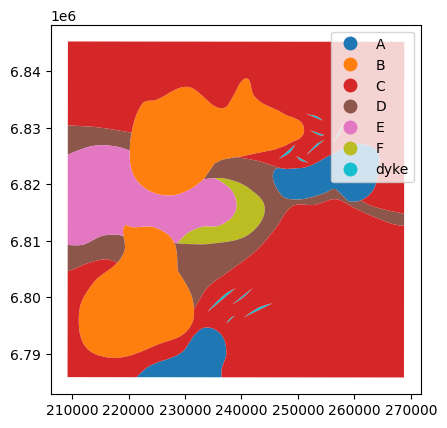

In [3]:
# Showing the columns in the DataFrame
print(input_polygon.columns)

# Showing the geological map
input_polygon.plot(column = "Litho", cmap = "tab10", legend=True)

The CBA object is first initialized, then completed using the **.init_from_vector_file()** function.

**"Litho"** contain unique values corresponding to various lithostratigraphic units. We use this column to identify the associations of lithologies with the CBA. 

Proceeding with the CBA, we initialize the object and then process the lithological dataset, targeting **"Litho"**.

The size of the cells is set to **5 000m**: units are based on the CRS used by the dataset (in this case, meters).

We use **"all"** the attributes within the targeted column **"Litho"**. Otherwise, we could specify which value to use to produce the matrix (a specific list containing only granites for example, coul be produced beforehand).

In [4]:
cba_grid = cba.CBA()
cba_grid.init_from_vector_file(cell_size = 4000,
                               vector_file_path = ("../tests/data/remote/Test_Litho.shp"),
                               target_attribut='Litho',
                              subset_of_target_attribut_values="all")
print(cba_grid.crs)

Columns: 15
Rows: 15
Cells: 225
CBA matrix computed in 0.1342 seconds
epsg:2154


### Overview of the results

An overview of the results can be created using basic *Geopandas* functions, such as **.head()** or **.plot()** on the **.cba** attribute of our CBA class

Checking the DataFrame, we can see that each lithology is represented by its own column. Its presence or absence inside each cell is indicated with either a 1 or a 0.

In [5]:
cba_grid.cba.head(1)

,geometry,A,B,C,D,E,F,dyke
cell_id,,,,,,,,
0,"POLYGON ((209204.985 6845305.213, 213204.985 6...",0,0,1,0,0,0,0


We can plot the cells containing a specific lithology.

<Axes: >

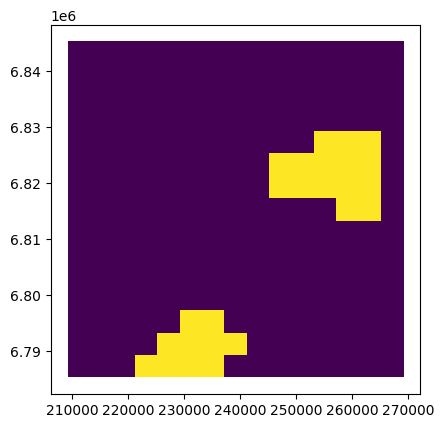

In [6]:
cba_grid.cba.plot(column ="A", cmap ="viridis")

Creating a unique code for each association of lithologies can also be done from the result of the CBA matrix.

['0010000' '0110000' '0011000' '0111000' '0100000' '0110001' '0010001'
 '0001100' '0111100' '1010001' '1010000' '0000100' '0100100' '0101000'
 '1011001' '1000000' '0101110' '0001110' '0001010' '1001000' '1011000'
 '0000110' '0101100' '0011010' '0011100' '0001000' '0011001' '1110000']


<Axes: >

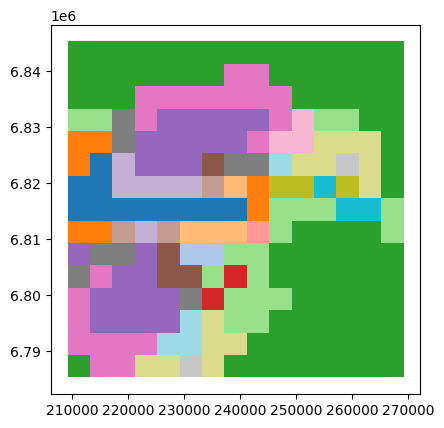

In [7]:
# Create a binary code for each cell based on the lithologies found inside each of them
cols = list(cba_grid.cba.columns); cols.remove("geometry")
Code_display = cba_grid.cba.copy(deep=True)
Code_display['CODE'] = cba_grid.cba[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# Display the unique associations of lithologies
print(Code_display['CODE'].unique())
Code_display.plot(column ="CODE", cmap ="tab20")

## Adding new data to the CBA matrix

Once a matrix have been produced, it is possible to add new data to it.

If needed, the matrix can be loaded from a saved **.csv** file or from a **.shp** file to complete it. Otherwise, if the class object is already loaded in the Python variables, we can directly add new data to it like in the following example.

### Points object (occurrences)

Points geometries can be added to the CBA matrix using **.shp** files.

To add new data, we use the **.add_layer()** function.

Occurences can be added based on the geometries within the vector file. No buffer are used and the name of the added column representing the absence/presence of each mineralization within the cells is **"Occ"**.

In [8]:
cba_grid.add_layer(vector_file_path = ("../tests/data/remote/Test_Occ.shp"),
                   target_attribut='',
                   subset_of_target_attribut_values=None,
                   Name = "Occ",
                   buffer = False)

Layer added in 0.0898 seconds


A new column has been added to the CBA matrix.

In [9]:
cba_grid.cba.head(1)

,geometry,A,B,C,D,E,F,dyke,Occ
cell_id,,,,,,,,,
0,"POLYGON ((209204.985 6845305.213, 213204.985 6...",0,0,1,0,0,0,0,0


We can check the location of the cells containing mineralization.

<Axes: >

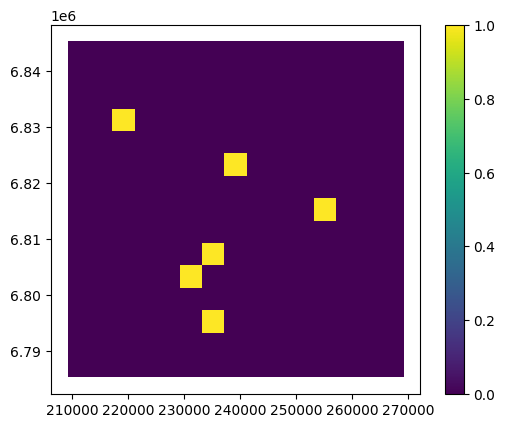

In [10]:
cba_grid.cba.plot(column ="Occ", cmap ="viridis", legend=True)

If wanted, we can use buffer to add the data to the CBA matrix. This can avoid border effects with the square grid, or allows increasing the sample of positive cells (i.e. containing at least one mineralization).

In this case, let's try with a buffer with a 4 000m diameter.

In [11]:
cba_grid.add_layer(vector_file_path = ("../tests/data/remote/Test_Occ.shp"),
                   target_attribut='',
                   subset_of_target_attribut_values=None,
                   Name = "Occ_B",
                   buffer = 4000)

Layer added in 0.2950 seconds


More cells will be identified as positives.

<Axes: >

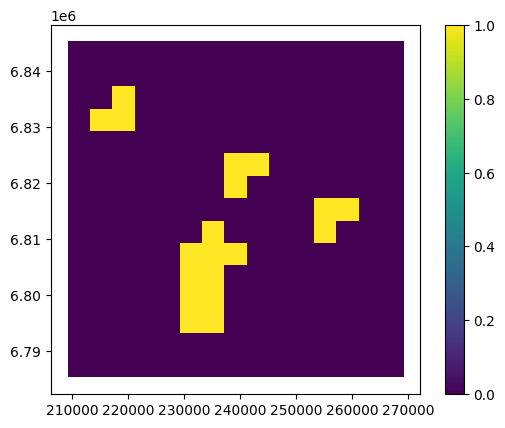

In [12]:
cba_grid.cba.plot(column ="Occ_B", cmap ="viridis", legend=True)

### Lines/Multilines object (faults)

Lines and Multilines geometries can be added to the CBA matrix using **.shp** files.

To add new data, we use the **.add_layer()** function.


<Axes: >

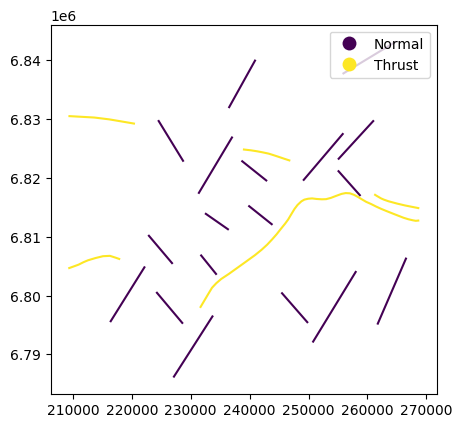

In [13]:
# Showing the type of faults
input_lines.Type.unique()

# Showing the geological map
input_lines.plot(column = "Type", cmap = "viridis", legend=True)

We have different types of faults. To differentiate them, we use the **target_attribut** and **subset_of_target_attribut_values** parameters.

Layer added in 0.1046 seconds


,geometry,A,B,C,D,E,F,dyke,Occ,Occ_B,Normal,Thrust
cell_id,,,,,,,,,,,,
0,"POLYGON ((209204.985 6845305.213, 213204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0


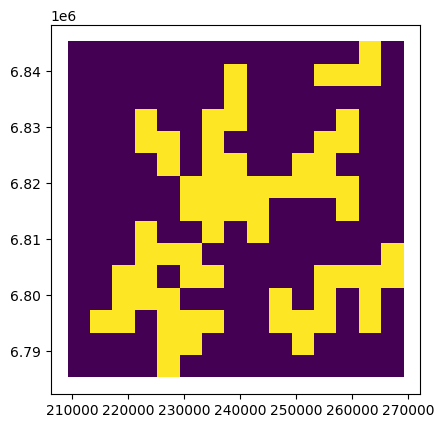

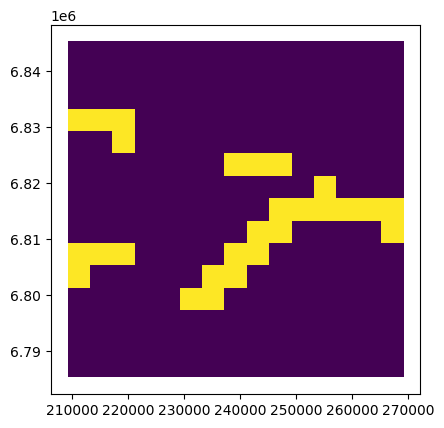

In [14]:
cba_grid.add_layer(vector_file_path = ("../tests/data/remote/Test_Faults.shp"),
                   target_attribut='Type',
                   subset_of_target_attribut_values=["Thrust","Normal"],
                   Name = None,
                   buffer = False)

# Plot the cells containing Normal Faults
cba_grid.cba.plot(column ="Normal")

# Plot the cells containing Thrust Faults
cba_grid.cba.plot(column ="Thrust")

# Display the content of the matrix
cba_grid.cba.head(1)

## Save

The CBA grid produced can be saved in a **.csv** or a **.shp** format.

In [15]:
cba_grid.to_csv("../tests/data/remote/Test_CBA_matrix")
cba_grid.to_shapefile("../tests/data/remote/Test_CBA_matrix")

CSV saved in 0.0271 seconds
Shapefile saved in 0.2478 seconds


In [16]:
cba_grid.cba

,geometry,A,B,C,D,E,F,dyke,Occ,Occ_B,Normal,Thrust
cell_id,,,,,,,,,,,,
0,"POLYGON ((209204.985 6845305.213, 213204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
1,"POLYGON ((213204.985 6845305.213, 217204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
2,"POLYGON ((217204.985 6845305.213, 221204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
3,"POLYGON ((221204.985 6845305.213, 225204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
4,"POLYGON ((225204.985 6845305.213, 229204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
220,"POLYGON ((249204.985 6789305.213, 253204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
221,"POLYGON ((253204.985 6789305.213, 257204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0
222,"POLYGON ((257204.985 6789305.213, 261204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0


## Load

Produced save file can also be loaded back into python using **.from_vector_file()** or **.from_csv()** function after initializing a CBA object.

First, let's import the **.shp** grid.

In [17]:
shp_cba_grid = cba.CBA()
shp_cba_grid = shp_cba_grid.from_vector_file("../tests/data/remote/Test_CBA_matrix.shp")

Then, the **.csv** grid.

In [18]:
csv_cba_grid = cba.CBA()
csv_cba_grid = csv_cba_grid.from_csv("../tests/data/remote/Test_CBA_matrix__epsg_2154.csv")

Both methods produce the same grid.

In [19]:
shp_cba_grid.cba.equals(csv_cba_grid.cba)

True

Adding new data to those loaded matrix is stil possible, using the same method as above, with the **.add_layer()** function.

Layer added in 0.2932 seconds


,geometry,A,B,C,D,E,F,dyke,Occ,Occ_B,Normal,Thrust,AllFault
cell_id,,,,,,,,,,,,,
0,"POLYGON ((209204.985 6845305.213, 213204.985 6...",0,0,1,0,0,0,0,0,0,0.0,0.0,0


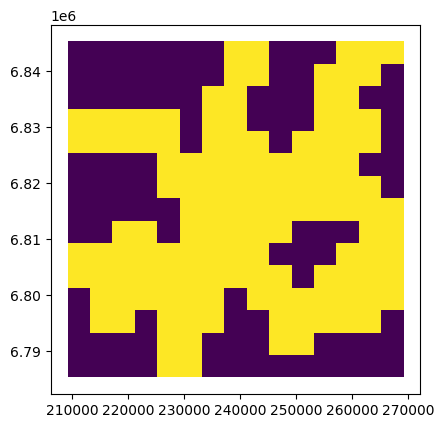

In [20]:
shp_cba_grid.add_layer(vector_file_path = ("../tests/data/remote/Test_Faults.shp"),
                   target_attribut='',
                   subset_of_target_attribut_values=None,
                   Name = "AllFault",
                   buffer = 4000)

# Plot the cells within 4 000m to any Faults
shp_cba_grid.cba.plot(column = "AllFault")

# Display the content of the matrix
shp_cba_grid.cba.head(1)